In [1]:
import torch

In [2]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")  # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('GPU not found, using CPU instead.')

Using GPU: NVIDIA GeForce MX230


In [3]:
import matplotlib.pyplot as plt

from elo_guesser.helper_functions import load_dataset
from elo_guesser.helper_functions import elo_range
from elo_guesser.models import lstm_network

In [4]:
rating_ranges = elo_range.get_rating_ranges()

### Load Analyzed Games

In [5]:
position_type = "boards_mirrors"
path = "../../datasets/"
dataset = load_dataset.load_games(position_type, path)
print("Total Games:", len(dataset))

Total Games: 20000


In [6]:
def modify_dataset(dataset):
    import random

    random.shuffle(dataset)

    total_games = len(dataset)
    test_games = int(total_games * 0.15)

    x_train = [game.to(device) for game, _ in dataset[:-test_games]]
    y_train = [elo_range.calculate_elo_range(elo).to(device)
               for _, elo in dataset[:-test_games]]
    x_test = [game.to(device) for game, _ in dataset[-test_games:]]
    y_test = [elo for _, elo in dataset[-test_games:]]

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = modify_dataset(dataset)

### Define the Model

In [7]:
def create_model(input_size):
    hidden_size = 128
    num_layers = 2
    learning_rate = 0.001
    lstm_model, optimizer = lstm_network.initialize_model(
        input_size, hidden_size, num_layers, device, learning_rate, num_classes=len(rating_ranges))
    return lstm_model, optimizer

lstm_model, optimizer = create_model(x_train[0].shape[-1])

### Train the model

In [8]:
# CrossEntropyLoss is commonly used for classification problems
# Since this is technically not a classification problem, I'm not sure it's the best choice 
loss_func = torch.nn.CrossEntropyLoss()

loss_graph = lstm_network.train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=15)

Epoch: 1, Validation Loss: 2.1221095688202802
Epoch: 2, Validation Loss: 2.045533866555083
Epoch: 3, Validation Loss: 2.014536595017302
Epoch: 4, Validation Loss: 2.0085100540460323
Epoch: 5, Validation Loss: 2.0019666361808777
Epoch: 6, Validation Loss: 2.0001671138464236
Epoch: 7, Validation Loss: 2.0116013575535194
Epoch: 8, Validation Loss: 2.0382615822436763
Epoch: 9, Validation Loss: 2.0560640729642383


KeyboardInterrupt: 

In [9]:
# To free CUDA memory
del x_train, y_train

### Plot the results

In [13]:
from elo_guesser.helper_functions import plot_results

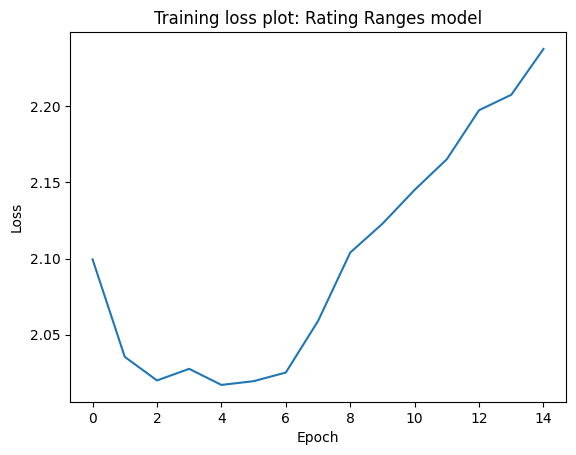

In [11]:
plot_results.plot_loss(loss_graph)

### Test predictions

In [10]:
def get_predictions(lstm_model, x_test):
    predictions = []
    for game in x_test:
        prediction, (_h, _c) = lstm_model(game, train=False)
        prediction = elo_range.guess_elo_from_range(prediction).cpu().detach()
        predictions.append(prediction)
    return predictions

predictions = get_predictions(lstm_model, x_test)

In [11]:
# Flatten the output vectors
y_test = torch.cat(y_test).view(-1)
predictions = torch.cat(predictions).view(-1)

Mean error: 237.5496826171875
50th percentile: 185.807861328125
90th percentile: 512.026123046875


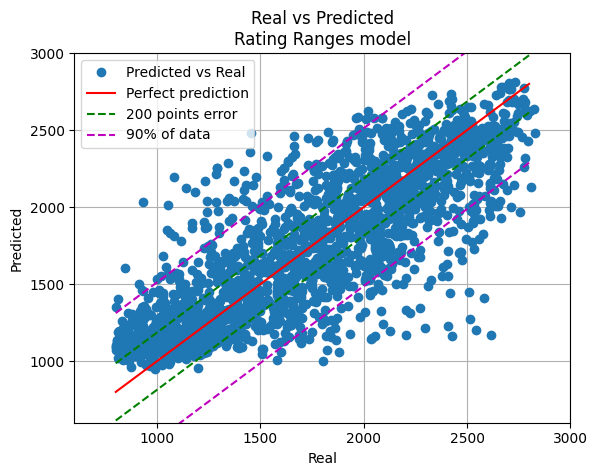

In [14]:
plot_results.compare_results(predictions, y_test)

In [16]:
def rate_predictions(predictions, y_test):
    leeway = 200
    difference = torch.abs(predictions - y_test)
    correct = (difference <= leeway).sum()
    
    return correct.item() / len(predictions)

correct_percentage = rate_predictions(predictions, y_test)
print(f"Correct predictions: {correct_percentage:.3f}")

Correct predictions: 0.534


In [ ]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"temp/{position_type}.pt")